<a href="https://colab.research.google.com/github/AlecTraas/computational-geo-lab/blob/main/Colab/Kai/quickhull_algo_3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import random as rnd

In [43]:
def main(num_points):
  points = sorted([[rnd.random()*10, rnd.random()*10, rnd.random()*10] for _ in range(num_points)], key=lambda x: x[0])
  np_points = np.array(points)
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')
  ax.scatter(np_points[:,0], np_points[:,1], np_points[:,2])
  hull = ConvexHull(np_points)
  hull.quick_hull()
  # Not sure how to plot triangles...
  np_hull_pts = np.array(hull.hull_points)
  np_hull_fcts = np.array(hull.hull_facets)
  ax.plot_trisurf(np_hull_pts[:, 0], np_hull_pts[:, 1], np_hull_pts[:, 2], triangles=np_hull_fcts, color='gray', alpha=0.5)
  plt.show()

In [48]:
# I miss structs :(
class ConvexHull():
  def __init__(self, points):
    # [[x,y,z]...]
    self.points = points
    # [[x,y,z]...]
    self.hull_points = None
    # references indecies in the hull_points array
    # [[a,b,c]...]
    self.hull_facets = None
    # references indecies in the hull_points array
    # [[a,b]...]
    self.hull_ridges = None
    # references indecies in the hull_ridges array
    # [a,b,c...]
    self.neighbors = None

  def quick_hull(self):
    # I assume, for the sake of simplicity, that no one will input fewer that 4 points
    self.define_tetrahedron()
    # self.clear_internal_points()

  def define_tetrahedron(self):
    # This works for the most part, though duplicates (e.g. values that are the min x and max y) screw things up.
    # My idea is that I can create a copy of self.points, and just make sure to remove points from the copy after adding each to i. This should allow us to avoid duplicates

    temp = self.points

    i = [self.points[:,0].argmin(),
        self.points[:,1].argmin(),
        self.points[:,2].argmin(),
        self.points[:,1].argmax()]

    i = sorted(i, reverse=True)

    self.hull_points = [self.points[j, :] for j in i]

    for j in i:
      self.points = np.delete(self.points,j,0)

    self.hull_points.sort(key=lambda x: x[0])
    self.hull_points = self.hull_points[::-1]

    self.hull_facets = [[0,2,1],[0,1,3],[0,3,2],[1,2,3]]
    self.neighbors = [[[0,3,2],[1,2,3],[0,1,3]],
                      [[0,2,1],[1,2,3],[0,3,2]],
                      [[0,1,3],[1,2,3],[0,2,1]],
                      [[0,2,1],[0,3,2],[0,1,3]]]

  def above_facet(self,face,point):
    # From what I can tell, this is functional
    face = self.hull_facets[face]
    n = np.cross((face[1]-face[0]),(face[2]-face[0]))
    n = n/np.linalg.norm(n)
    d = np.dot(n,(face[0]-point))
    return d > 0

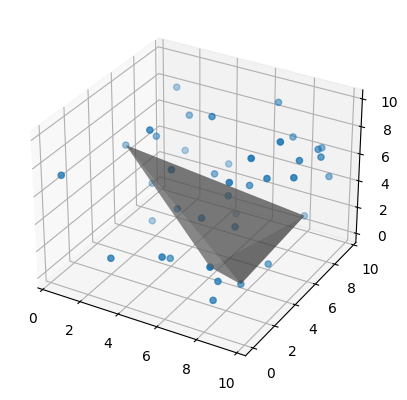

In [60]:
main(40)